In [1]:
import os

os.chdir("../")

from dotenv import load_dotenv

%load_ext autoreload
%autoreload 2

load_dotenv(".env")

True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import constants

# Data preparation imports
from src.features.feature_service import FeatureService
from src.features.feature_generators.technical_indicators import *
from src.features.feature_generators.datetime import DateTime
from src.labelers import BinaryLabeler, BinarySmoothLabeler

# Model imports
from src.model.datasets import SlidingWindowDataset
from src.model.architectures import TransformerBinaryClassifier
from src.model.wrappers import BinaryModelWrapper

# Backtester imports
from src.evaluation.metrics import evaluate_binary
from src.evaluation import Backtester

In [3]:
# Plot styling
TEXT_COLOR = "#313131"

# Plotly colors
LINE_COLORS = [
    "#636EFA",
    "#EF553B",
    "#00CC96",
    "#AB63FA",
    "#FFA15A",
    "#19D3F3",
    "#FF6692",
    "#B6E880",
    "#FF97FF",
    "#FECB52",
]

sns.set(
    style="darkgrid",
    rc={
        "figure.figsize": (6, 4),
        "figure.dpi": 100,
        "figure.facecolor": "w",
        "legend.facecolor": "w",
        "text.color": TEXT_COLOR,
        "font.family": "Microsoft Sans Serif",
        "axes.labelcolor": TEXT_COLOR,
        "xtick.color": TEXT_COLOR,
        "ytick.color": TEXT_COLOR,
    },
)

sns.set_palette(sns.color_palette(LINE_COLORS))

In [70]:
# Dataset config
ASSET_TO_TRADE = "ADA"
PREDICTOR_ASSETS = ["BTC", "ETH", "LTC", "XRP", "BNB", "XRP"]  # ADA
FIAT_TO_TRADE = "USDT"

# Labeler config
TARGET_COL = f"{ASSET_TO_TRADE}{FIAT_TO_TRADE}_close"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TARGET_PERIOD = 15

# Transformer params
SEQ_LEN = 100  # predict, using data from the last 20 intervals
N_HEAD = 8  # attention heads in each transformer layer, typically 8
N_EMBEDDING_DIMS = 64  # 512 in the original paper but that's for a huge vocab
N_LAYERS_TRANSFORMER = 2  # 6 in the original paper

# LSTM params
N_HIDDEN = 512
N_LAYERS_LSTM = 3

# Learning params
BATCH_SIZE = 512
LR = 2e-2
LR_DECAY_MULTIPLIER = 0.9
LR_DECAY_STEP = 3

# Backtesting
GAP_PROPORTION = 0.05
VALID_PROPORTION = 0.20
N_SPLITS = 1
N_EPOCHS = 2

# Create dataset

In [71]:
df = pd.read_parquet("data/binance")

In [72]:
# Get only 10k rows to test the functionality
df = df.iloc[:10000]

### Generate features

In [73]:
symbols = [
    f"{asset}{constants.FIAT_TO_TRADE}" 
    for asset in [constants.ASSET_TO_TRADE, *constants.PREDICTOR_ASSETS] 
]

generators = []

# Moving averages
generators += [
    indicator(input_col=f"{symbol}_close", period=period)
    for indicator in [EMA, SMA]
    for symbol in symbols
#     for period in [9, 21, 50]
    for period in [5, 15, 60, 200]
]

# MACD
generators += [
    MACD(
        input_col=f"{symbol}_close", 
        fast_period=6, 
        slow_period=13, 
        signal_period=5,
    )
    for symbol in symbols
]

# RSI
generators += [
    RSI(input_col=f"{symbol}_close")
    for symbol in symbols
]

# Bollinger bands
generators += [
    BB(input_col=f"{symbol}_close", period=20, std_dev_multiplier=2)
    for symbol in symbols
]

# Bollinger band percentile
generators += [
    BBP(input_col=f"{symbol}_close", std_dev_multiplier=2)
    for symbol in symbols
    for period in [20, 200]
]

# OBV
generators += [
    OBV(
        close_col=f"{symbol}_close",
        volume_col=f"{symbol}_volume",
    )
    for symbol in symbols
]

# ATR
generators += [
    ATR(
        high_col=f"{symbol}_high",
        low_col=f"{symbol}_low",
        close_col=f"{symbol}_close",
        period=10,
    )
    for symbol in symbols
]

# VWAP
generators += [
    VWAP(
        high_col=f"{symbol}_high",
        low_col=f"{symbol}_low",
        close_col=f"{symbol}_close",
        volume_col=f"{symbol}_volume",
    )
    for symbol in symbols
]

# DateTime
generators += [
    DateTime(timestamp_col="open_timestamp")
]

In [74]:
service = FeatureService(*generators)

In [75]:
%%time
service.initialize(df)

CPU times: user 5.38 s, sys: 113 ms, total: 5.5 s
Wall time: 5.5 s


In [76]:
%%time
# Features DF
features_df = pd.DataFrame(service.output_values)

CPU times: user 170 ms, sys: 18.7 ms, total: 189 ms
Wall time: 188 ms


In [77]:
# plt.figure(figsize=(30,30))
# sns.heatmap(features_df.dropna().corr(), cmap="RdYlGn", center=0, lw=0.01)

### Generate labels

In [78]:
# labeler = BinaryLabeler(price_col=TARGET_COL, period=TARGET_PERIOD)

In [79]:
labeler = BinarySmoothLabeler(price_col=TARGET_COL, period=TARGET_PERIOD)

In [80]:
features_df["target"] = labeler.transform(df)

---

### Prepare data for training

In [81]:
data = pd.concat(
    (df, features_df),
    axis=1,
).dropna()

In [82]:
neg_kws = [
    "number_of_trades",
    "quote_asset_volume",
    "taker_buy_base_asset_volume",
    "taker_buy_quote_asset_volume",
]

for kw in neg_kws:
    cols = data.columns
    cond = cols.str.contains(kw)
    selected_cols = cols[~cond]
    data = data[selected_cols]

In [83]:
x = data.drop(["time", "open_timestamp", "date", "target"], axis=1).astype(float)
y = data["target"].astype(float)

<Axes: >

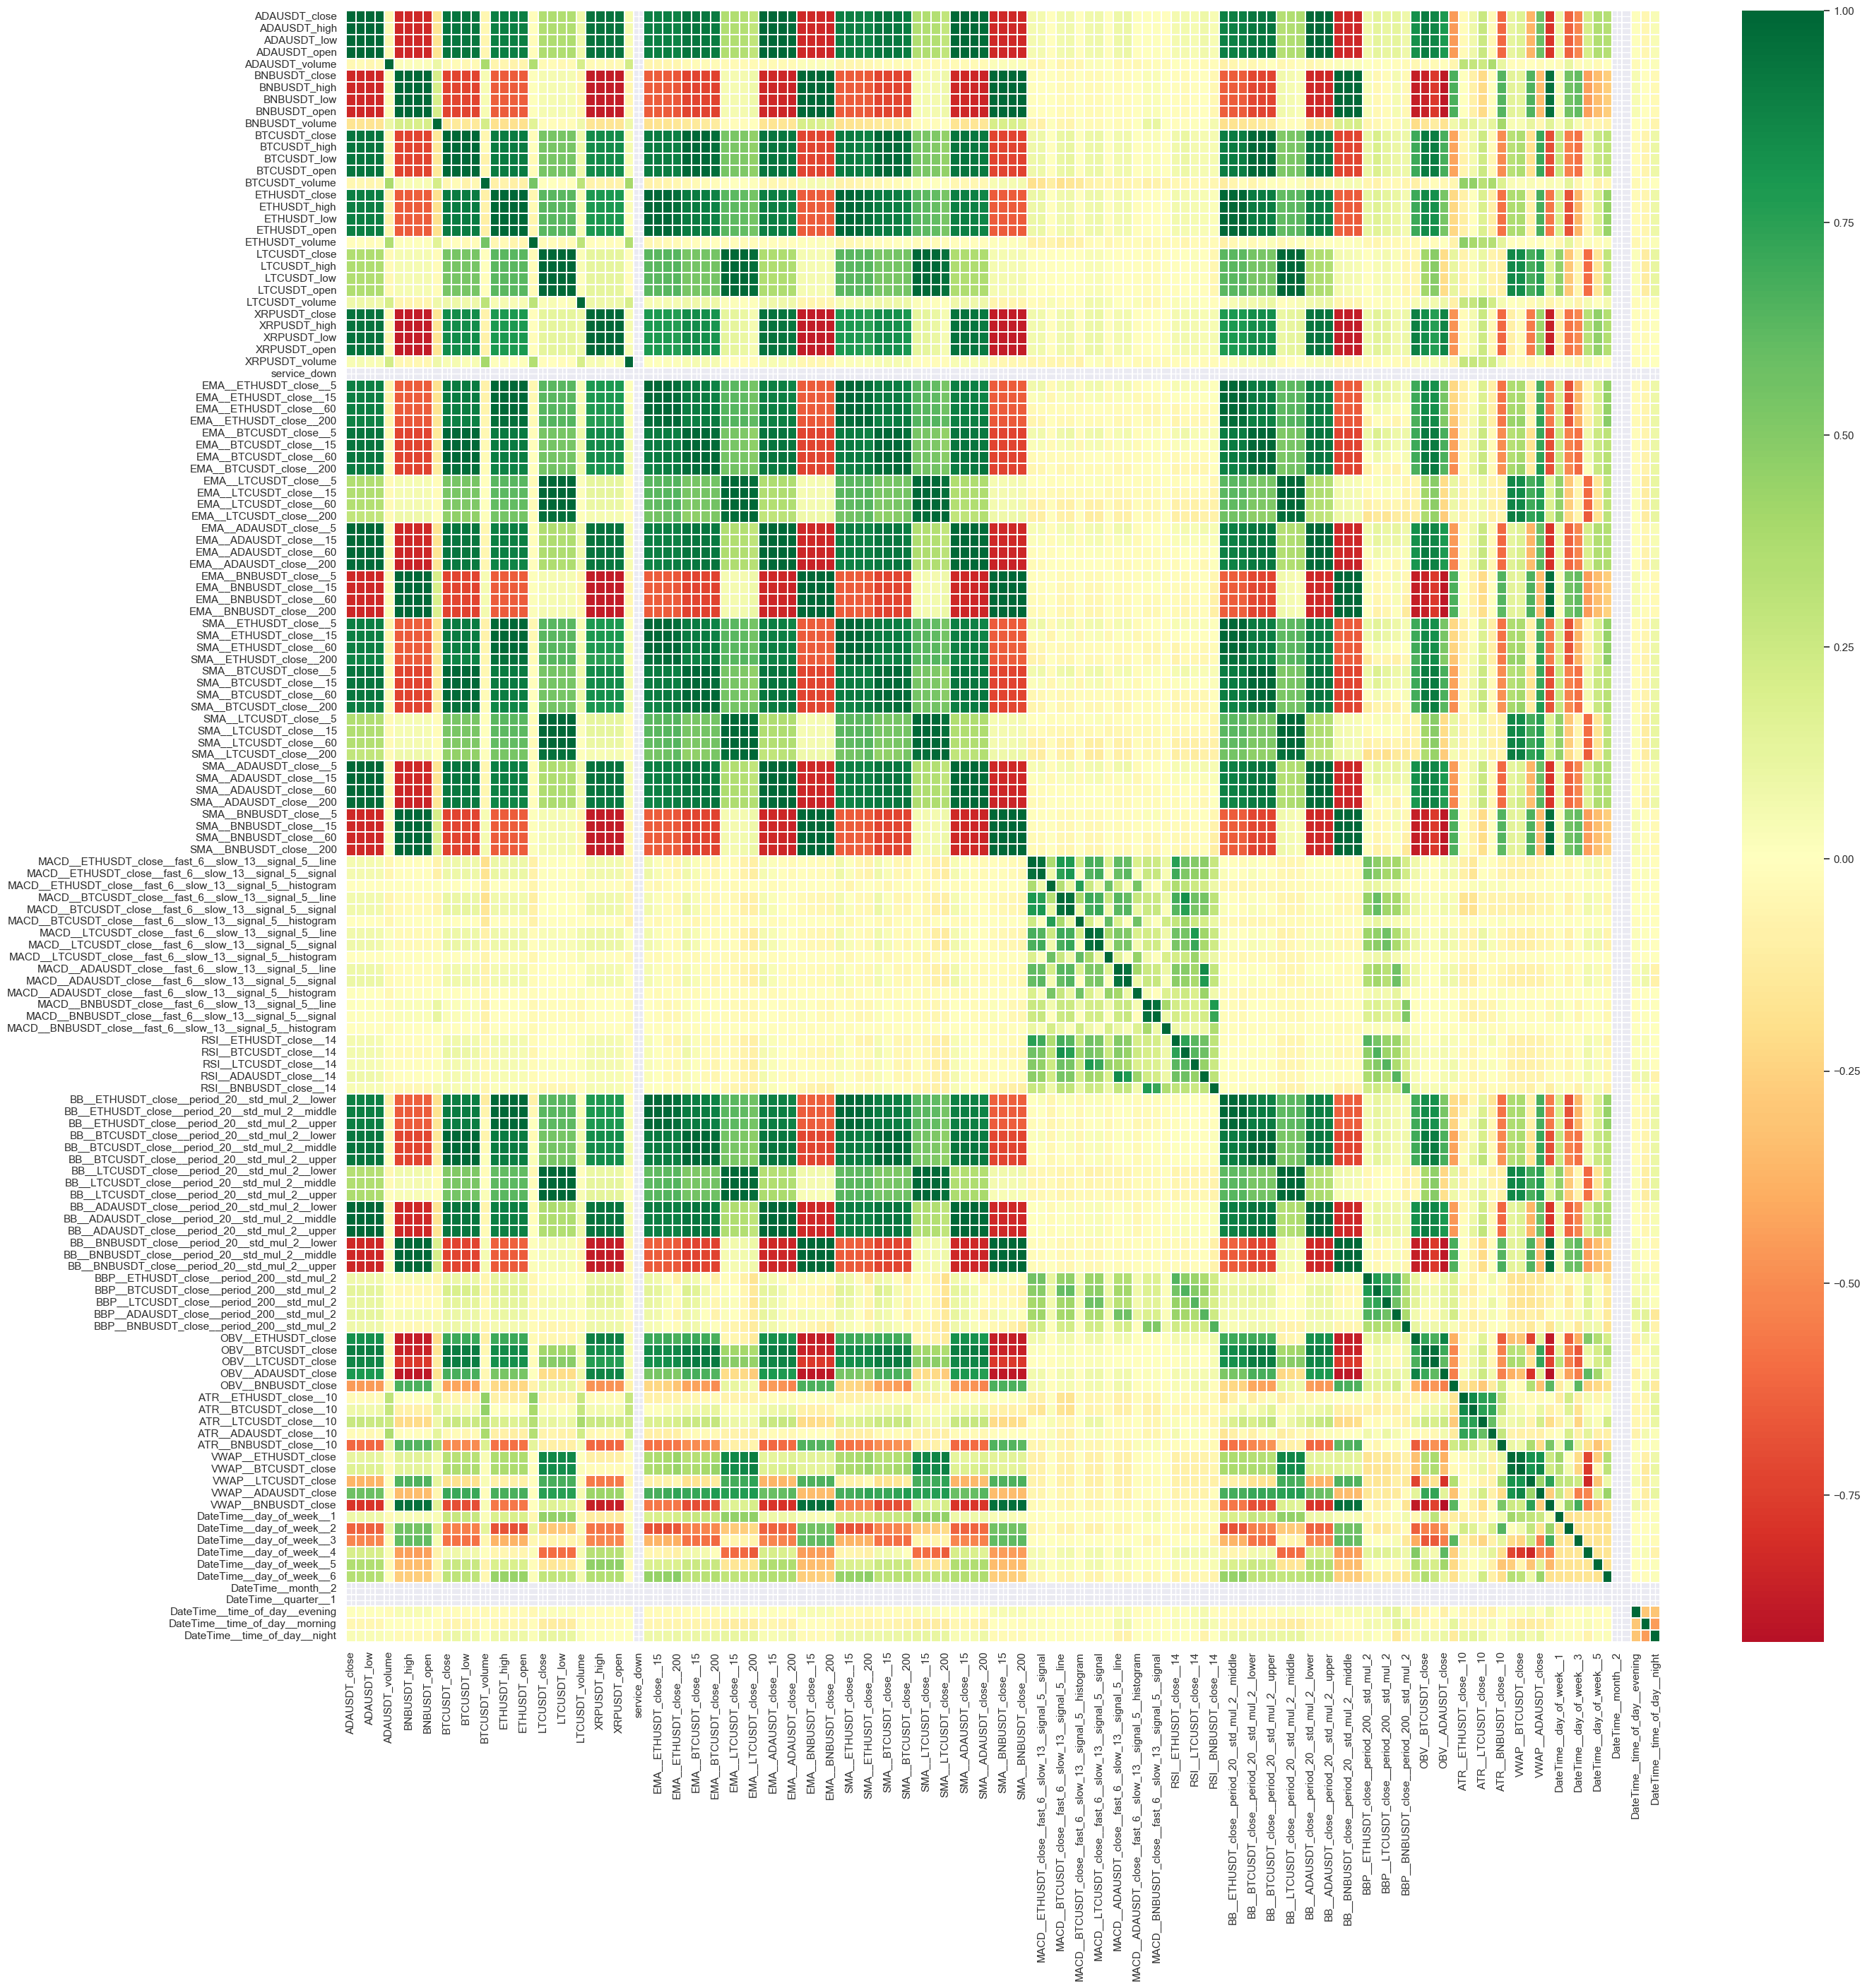

In [85]:
plt.figure(figsize=(30,30))
sns.heatmap(x.dropna().corr(), cmap="RdYlGn", center=0, lw=0.01)

### Preprocess

In [86]:
x = torch.Tensor(x.values).to(torch.float).to(DEVICE)
y = torch.Tensor(y.values).to(torch.float).to(DEVICE)

In [87]:
x.size(), y.size()

(torch.Size([9786, 137]), torch.Size([9786]))

In [88]:
torch.isnan(x).sum()

tensor(0)

---

# Run Backtest

In [89]:
from src.model.preprocessors import StandardScaler
from src.model.architectures import LSTMBinaryClassifier

In [90]:
# model = LSTMBinaryClassifier(
#     n_features=x.size(1),
#     n_hidden=N_HIDDEN_LSTM,
#     n_layers=N_LAYERS_LSTM,
#     n_out=1,
# )

In [91]:
model = TransformerBinaryClassifier(
    n_features=x.size(1),
    n_embedding_dims=N_EMBEDDING_DIMS,
    n_head=N_HEAD,
    n_layers=N_LAYERS_TRANSFORMER,
    n_out=1,
)

In [92]:
wrapper = BinaryModelWrapper(
    model=model,
    batch_size=BATCH_SIZE,
    loss_fn=torch.nn.BCELoss(),
    dataset_builder=SlidingWindowDataset,
    dataset_builder_kwargs={"seq_len": SEQ_LEN},
    preprocessors=[StandardScaler(dim=0)],
    lr=LR,
    lr_decay_multiplier=LR_DECAY_MULTIPLIER,
    lr_decay_step=LR_DECAY_STEP,
)

In [93]:
backtester = Backtester(
    wrapper=wrapper,
    evaluation_fn=evaluate_binary,
    x=x,
    y=y,
    gap_proportion=GAP_PROPORTION,
    valid_proportion=VALID_PROPORTION,
    n_splits=1,
    n_epochs=N_EPOCHS,
)

In [ ]:
backtester.run()

Split 1
Train start: 0 | Train end: 7339 | Valid start: 7828 | Valid end: 9786
TRAINING EPOCH
`inputs` shape: torch.Size([512, 100, 137])
`inputs` example: tensor([[-1.8888, -1.9197, -1.8558,  ..., -0.4421, -0.6411,  1.3907],
        [-1.8888, -1.9197, -1.8558,  ..., -0.4421, -0.6411,  1.3907],
        [-1.8465, -1.8773, -1.8558,  ..., -0.4421, -0.6411,  1.3907],
        ...,
        [-1.9099, -1.9197, -1.8769,  ..., -0.4421, -0.6411,  1.3907],
        [-1.9099, -1.9408, -1.8769,  ..., -0.4421, -0.6411,  1.3907],
        [-1.9099, -1.9408, -1.8769,  ..., -0.4421, -0.6411,  1.3907]])
`inputs` mean and std: -1.415354609489441, 1.2437307834625244
`targets` shape: torch.Size([512])
`targets` example: 1.0


---

# Further debug

### Visualize the sequences

In [75]:
dl = wrapper.build_dataloader(x)
x_ = dl.dataset.x

In [76]:
for preprocessor in wrapper.preprocessors:
    x_ = preprocessor.transform(x_)

In [83]:
x_numpy = x_.numpy()

In [84]:
# for i, c in enumerate(data.drop(["time", "date", "open_timestamp", "target"], axis=1)):
#     print(i, "\t", c)

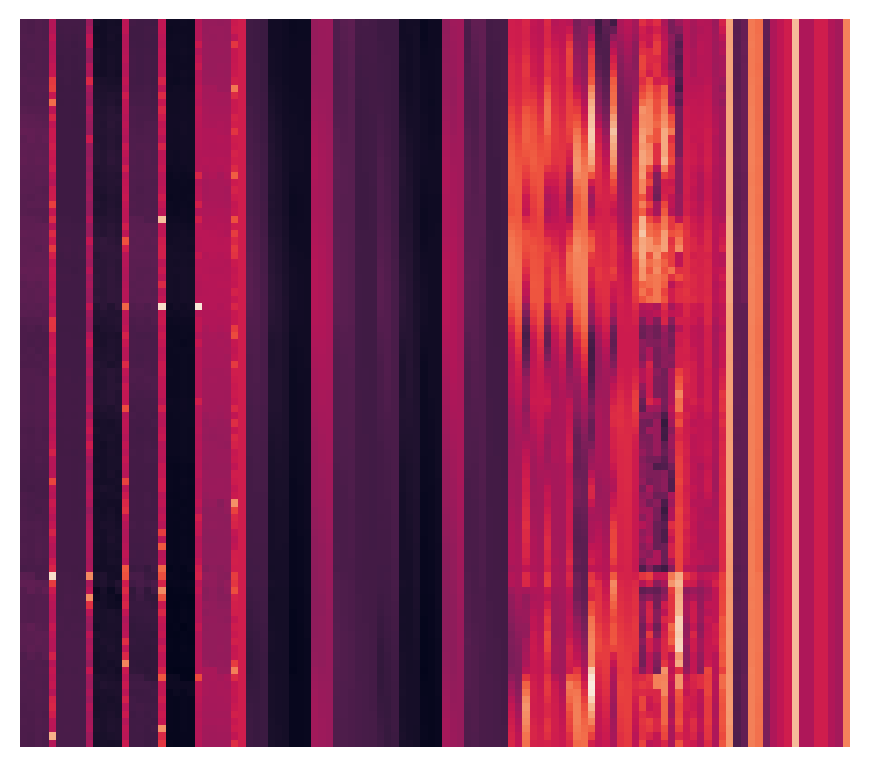

In [89]:
import matplotlib.animation as animation
from IPython.display import HTML

# Assuming `frames` is your list of 2D numpy arrays
frames = [np.random.rand(10, 10) for _ in range(100)]  # replace with your list of frames

fig, ax = plt.subplots(dpi=200)

# Function to update figure
def update(num):
    ax.clear()
    ax.imshow(x_numpy[num])
    plt.axis("off")
    plt.tight_layout()

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(frames), repeat=True)

ani.save('animation.gif', writer='pillow')

# HTML(ani.to_html5_video())

---

### Explore DFs

In [26]:
features = pd.read_parquet("data/features.parquet")

In [37]:
cols = features.columns
selected_cols = cols[cols.str.contains("ADA")].tolist()
features[selected_cols].mean()

ADAUSDT_close                                                 5.655886e-01
ADAUSDT_high                                                  5.661788e-01
ADAUSDT_low                                                   5.649740e-01
ADAUSDT_number_of_trades                                      1.909392e+02
ADAUSDT_open                                                  5.655868e-01
ADAUSDT_quote_asset_volume                                    1.256512e+05
ADAUSDT_taker_buy_base_asset_volume                           9.632263e+04
ADAUSDT_taker_buy_quote_asset_volume                          6.225115e+04
ADAUSDT_volume                                                1.952811e+05
EMA__ADAUSDT_close__9                                         5.655880e-01
EMA__ADAUSDT_close__21                                        5.655870e-01
EMA__ADAUSDT_close__50                                        5.655846e-01
SMA__ADAUSDT_close__9                                         5.655880e-01
SMA__ADAUSDT_close__21   

In [43]:
features["date"] = features["date"].astype("datetime64")

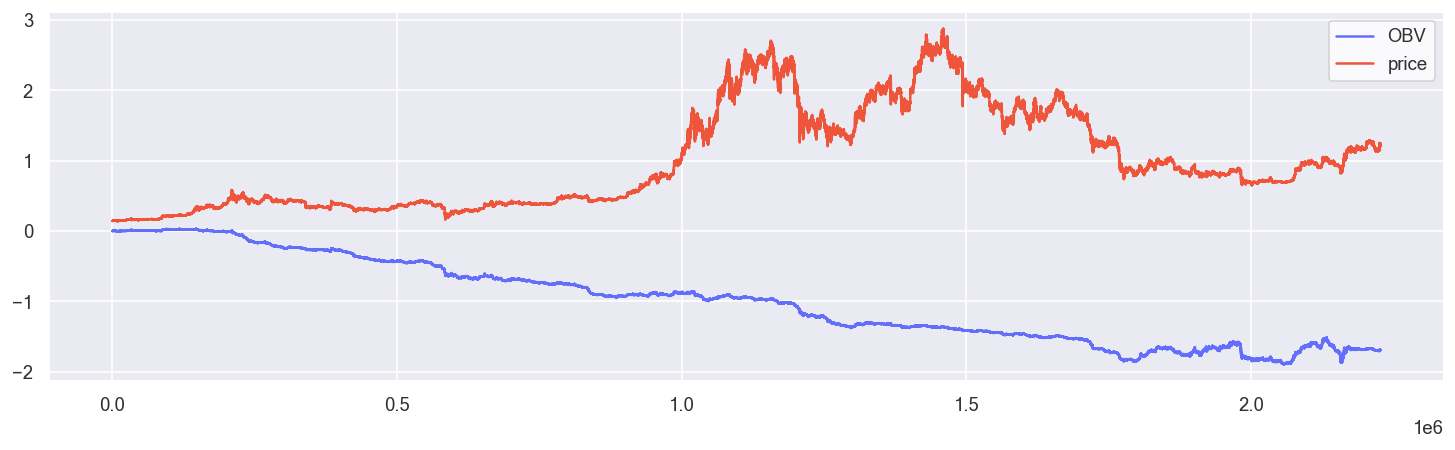

In [167]:
plt.figure(figsize=(15,4), dpi=120)
plot_normed(features, "OBV__BTCUSDT_close", "OBV")
# plot_normed(features, "BTCUSDT_volume", "volume")
plot_normed(features, "BTCUSDT_close", "price")
plt.legend()

In [102]:
def plot_normed(df, col, label, ax=None):
    normed = df[col] / abs(df[col].mean())
    normed.plot(label=label, ax=ax)

In [65]:
features_ = features[features["date"] >= "2021-01-01"]

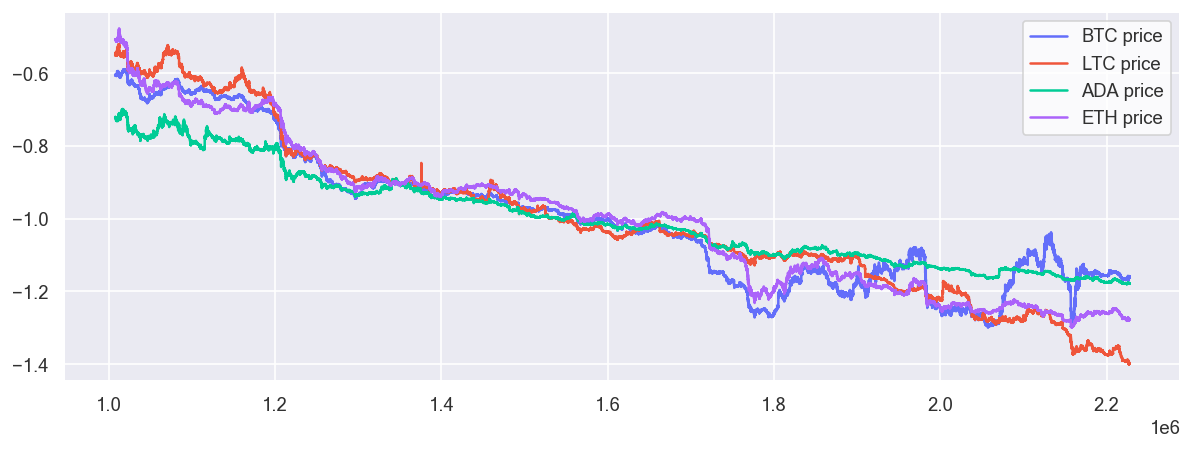

In [108]:
# OBV
plt.figure(figsize=(12,4), dpi=120)
for col in ["BTC", "LTC", "ADA", "ETH"]:
    plot_normed(features_, f"OBV__{col}USDT_close", f"{col} price")
plt.legend()

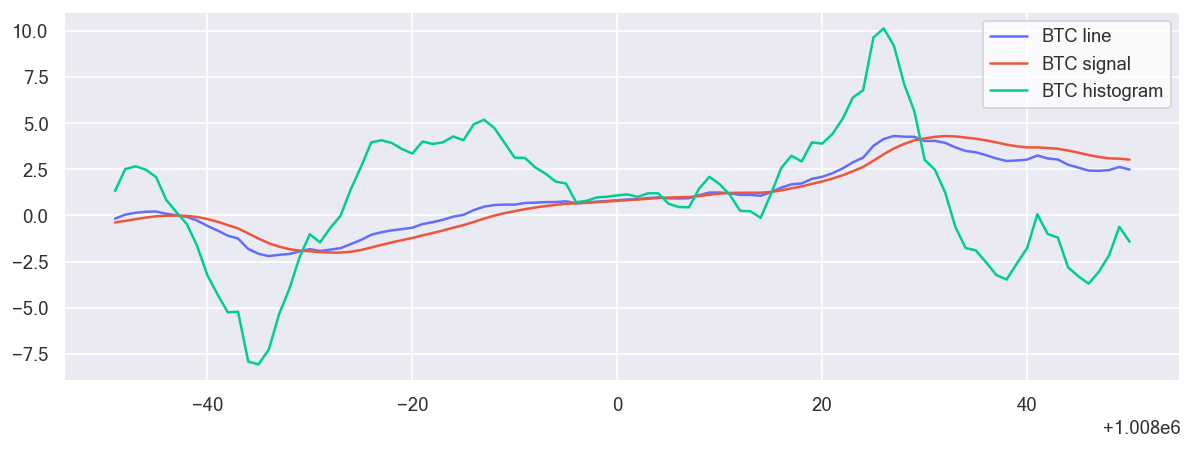

In [183]:
# MACD
plt.figure(figsize=(12,4), dpi=120)
for sym in ["BTC"]:
    for type_ in ["line", "signal", "histogram"]:
        col = f"MACD__{sym}USDT_close__fast_12__slow_26__signal_9__{type_}"
        plot_normed(features_[:100], col, f"{sym} {type_}")
        plt.legend()

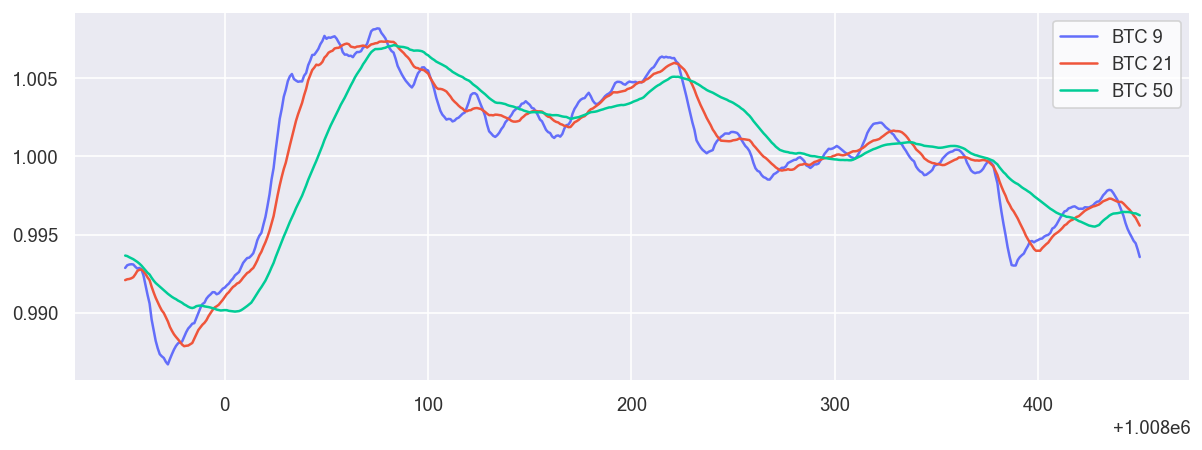

In [213]:
# MACD
plt.figure(figsize=(12,4), dpi=120)
for sym in ["BTC"]:
    for period in [9, 21, 50]:
        col = f"SMA__{sym}USDT_close__{period}"
        plot_normed(features_[:500], col, f"{sym} {period}")
        plt.legend()

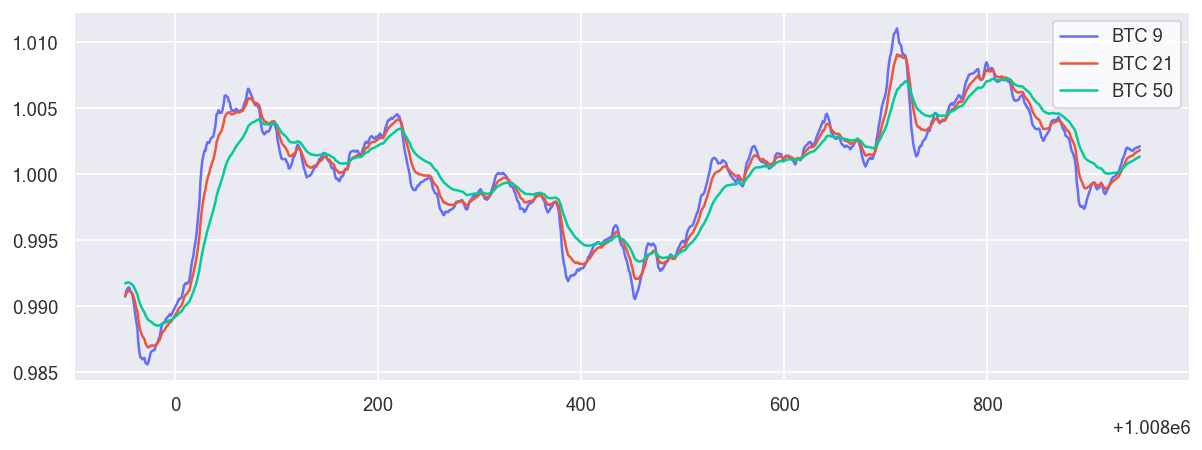

In [212]:
# MACD
plt.figure(figsize=(12,4), dpi=120)
for sym in ["BTC"]:
    for period in [9, 21, 50]:
        col = f"EMA__{sym}USDT_close__{period}"
        plot_normed(features_[:1000], col, f"{sym} {period}")
        plt.legend()

In [37]:
cols = features.columns
selected_cols = cols[cols.str.contains("ADA")].tolist()
features[selected_cols].mean()

ADAUSDT_close                                                 5.655886e-01
ADAUSDT_high                                                  5.661788e-01
ADAUSDT_low                                                   5.649740e-01
ADAUSDT_number_of_trades                                      1.909392e+02
ADAUSDT_open                                                  5.655868e-01
ADAUSDT_quote_asset_volume                                    1.256512e+05
ADAUSDT_taker_buy_base_asset_volume                           9.632263e+04
ADAUSDT_taker_buy_quote_asset_volume                          6.225115e+04
ADAUSDT_volume                                                1.952811e+05
EMA__ADAUSDT_close__9                                         5.655880e-01
EMA__ADAUSDT_close__21                                        5.655870e-01
EMA__ADAUSDT_close__50                                        5.655846e-01
SMA__ADAUSDT_close__9                                         5.655880e-01
SMA__ADAUSDT_close__21   

In [ ]:
BB__ADAUSDT_close__upper

### Calculate BBP

In [160]:
from src.features.feature_generators.technical_indicators import (
    EMA, SMA, BB, OBV, MACD, RSI, BBP, ATR
)

In [119]:
from talipp.indicators import BB as BB_talipp

In [145]:
bbp = BBP(
    input_col="BTCUSDT_close",
    period=200,
    std_dev_multiplier=2,
)

In [147]:
bbp.initialize(data.iloc[:1000])

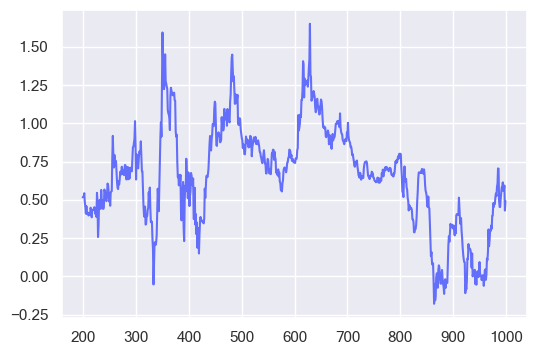

In [149]:
plt.plot(bbp.output_values)

In [138]:
prices = np.array(bb.talipp_instance.input_values)

In [139]:
lower = np.array(bb.output_values["lower"])
upper = np.array(bb.output_values["upper"])

In [142]:
out = (prices - lower) / (upper - lower)

{'lower': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  3425.2499839111747,
  3425.2536430247073,
  3425.176811107048,
  3425.26929353675,
  3425.3755697615948,
  3425.3807390231277,
  3425.2476804682137,
  3424.8803692421534,
  3424.3545509746436,
  3423.8640112612757,
  3423.2935381949587,
  3422.6165791599165,
  3421.2673447442307,
  3420.0306143104467,
  3419.60822918285,
  3419.4306914066583,
  3418.9979612269603,
  3418.2708567935424,
  3418.131999724138,
  3418.1283450103583,
  3418.1920482659402,
  3418.299984806002,
  3418.3474830836385,
  3418.6249904227293,
  3419.108883596165,
  3419.4805703337106,
  3419.6560906515238,
  3419.693718542386,
  3419.697551798124,
  3419.695409720591,
  3419.6356205439083,
  3419.6261038544694,
  3420.1129824271466,
  3420.806551552363,
  3420.7736202451547,
  3420.5529930817693,
  3420.492327570791,
  3418.1919193067015,
  3414.923863310554,
  3413.0005139

/var/folders/q_/10kbwhdx04lc4nptpgk0fklm0000gp/T/ipykernel_1597/4154822864.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


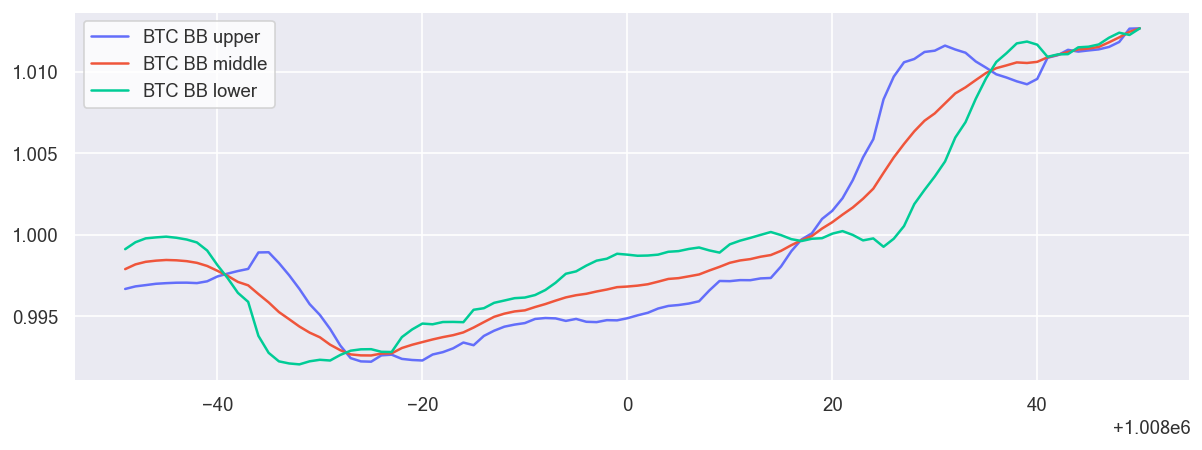

In [118]:
# BB
for col in ["BTC", "LTC", "ADA", "ETH"]:
    fig,ax = plt.subplots(figsize=(12,4), dpi=120)
    for type_ in ["upper", "middle", "lower"]:
        plot_normed(features_.iloc[:100], f"BB__{col}USDT_close__{type_}", f"{col} BB {type_}", ax=ax)
    fig.show()
    plt.legend()
    break
    

<Axes: >

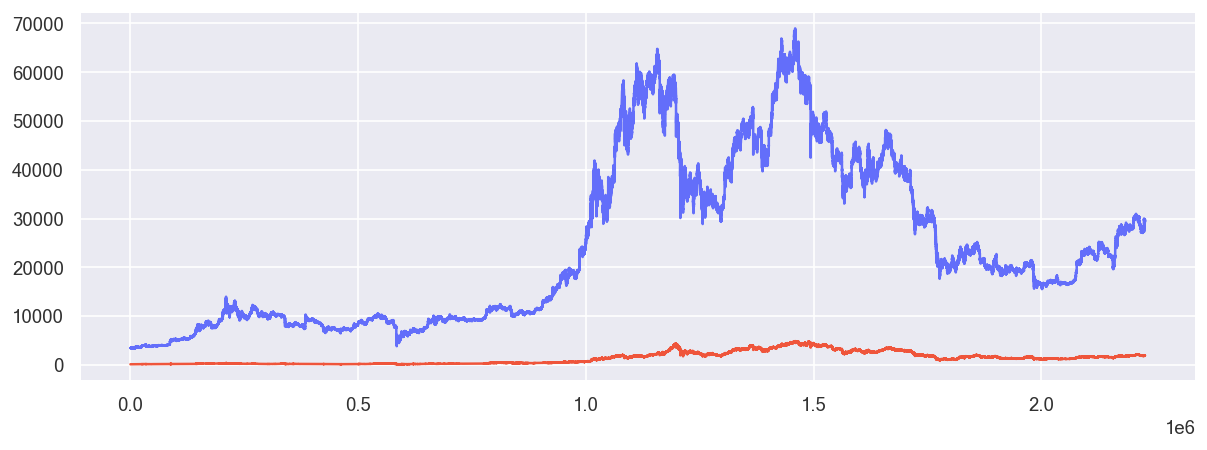

In [53]:
plt.figure(figsize=(12,4), dpi=120)
features["BTCUSDT_close"].plot(label="BTC")
features["ETHUSDT_close"].plot(label="ETH")

In [25]:
wrapper.fit(x, y)

Epoch: 1 | Train Loss: 0.704
Epoch: 2 | Train Loss: 0.691
Epoch: 3 | Train Loss: 0.687
Epoch: 4 | Train Loss: 0.687
Epoch: 5 | Train Loss: 0.684
Epoch: 6 | Train Loss: 0.693
Epoch: 7 | Train Loss: 0.684
Epoch: 8 | Train Loss: 0.683
Epoch: 9 | Train Loss: 0.679
Epoch: 10 | Train Loss: 0.690


---